## Importing the libraries

In [284]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

from sklearn.preprocessing import StandardScaler

import pickle

from numpy.random import seed

from tensorflow import set_random_seed

In [285]:
seed(2019)
set_random_seed(2019)

## Helper Functions

In [2]:
def calc_RMSE(validation_data, prediction_data):
   """
   Calculate RMSE
   """
   a = np.array(validation_data)
   b = np.array(prediction_data)

   return np.sqrt(np.mean((b-a)**2))

In [3]:
def get_fuller_test(series):
    values = series.values
    result = adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [4]:
def make_plots(data, lags=None):
    '''
    plotting the data with specified number of lags.
    plotting raw data, then ACF and PACF
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax = raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags = lags, ax = acf)
    smt.graphics.plot_pacf(data, lags = lags, ax = pacf)
    sns.despine()
    plt.tight_layout()

In [5]:
def make_plots_2(data, lags=None):
    '''
    plotting rolling mean, rolling std and original as per number of lags
    '''
    rolling_mean = data.rolling(window = lags).mean()
    rolling_std = data.rolling(window = lags).std()
    
    original = plt.plot(data, color='black',label = 'Original Timeseries')
    mean = plt.plot(rolling_mean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolling_std, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Original, Rolling Mean, Standard Deviation')
    sns.despine()
    plt.show()

In [6]:
def split_train_test_chronological(df, ratio = 0.9):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    '''
    
    size = len(df) * ratio
    size_round = round(size)
    
    df_train = df[0:(size_round)]
    df_test = df[size_round:]
    
    return df_train, df_test

## Importing data

In [7]:
df_bitcoin_price = pd.read_pickle('../crypto_currency_and_market_value_history/data/bitcoin_4_year_hourly_history_df.pickle')

In [8]:
df_bitcoin_price.head(3)

,timestamp,open,high,low,close,volume (btc),volume (currency),weighted price
0,2015-05-31 00:00:00,232.11,232.11,231.92,231.92,223.37,51822.18,232.00
1,2015-05-31 01:00:00,231.88,232.32,231.87,232.32,217.49,50452.68,231.98
2,2015-05-31 02:00:00,231.97,232.51,231.88,232.51,46.45,10782.23,232.14


In [294]:
df_vix_daily = pd.read_pickle('../crypto_currency_and_market_value_history/data/vix_volatility_daily_change_history_df.pickle')


In [295]:
df_vix_daily.head(3)

,trade date,open,high,low,close,settle,change,total volume
0,2019-06-07,-0.014837,-0.019264,-0.006116,0.006591,0.015175,-2.666667,-0.066600
1,2019-06-06,-0.023754,-0.021143,-0.015060,0.002402,-0.009023,-0.750000,-0.038795
2,2019-06-05,-0.054247,-0.047360,-0.034884,-0.032539,-0.034833,-0.428571,-0.149433


In [299]:
df_vix_hourly = pd.read_pickle('../crypto_currency_and_market_value_history/data/vix_volatility_hourly_history_df.pickle')


In [300]:
df_vix_hourly.head(3)

,Open,High,Low,Close,Volume,local_time
0,19.14,19.14,19.14,19.14,0.0,2017-01-25 16:00:00+00:00
1,19.14,19.14,19.14,19.14,0.0,2017-01-25 17:00:00+00:00
2,19.14,19.14,19.14,19.14,0.0,2017-01-25 18:00:00+00:00


In [11]:
df_gold = pd.read_csv('../crypto_currency_and_market_value_history/data/gold_hourly_data.csv', sep = ';')

In [346]:
df_gold.tail(3)

,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
12933,21/01/2019 21:00,0.131914,917.0,186.0,421.0,310.0,-0.470776,0.495320,3580.26,3582.38,3559.74,3560.70,117607867,"2670000000000000,00"
12934,21/01/2019 22:00,0.082912,929.0,247.0,377.0,305.0,-0.409633,0.472690,3561.58,3569.04,3535.19,3567.92,18324.54,"2750000000000000,00"
12935,21/01/2019 23:00,0.122160,899.0,168.0,355.0,376.0,-0.372583,0.485678,3569.34,3579.33,3569.34,3573.67,10105.2,"2760000000000000,00"


## Preprocessing

In [13]:
df_vix = df_vix.sort_values(by=['trade date']).reset_index()

In [14]:
df_vix.head(3)

,index,trade date,open,high,low,close,settle,change,total volume
0,3509,2005-06-21,0.004720,0.004720,0.004720,0.004720,0.005394,-0.994606,NaN
1,3508,2005-06-22,-0.004027,-0.004027,-0.004027,-0.004027,-0.003353,-1.625000,-0.8
2,3507,2005-06-23,0.009434,0.014151,0.004717,0.014151,0.017497,-6.200000,5.1


In [15]:
df_vix.drop(['index'], axis = 1, inplace = True)

In [16]:
df_vix.tail(3)

,trade date,open,high,low,close,settle,change,total volume
3507,2019-06-05,-0.054247,-0.047360,-0.034884,-0.032539,-0.034833,-0.428571,-0.149433
3508,2019-06-06,-0.023754,-0.021143,-0.015060,0.002402,-0.009023,-0.750000,-0.038795
3509,2019-06-07,-0.014837,-0.019264,-0.006116,0.006591,0.015175,-2.666667,-0.066600


## Processing for FB Prophet

In [18]:
df_bitcoin_price_FBP = df_bitcoin_price.copy()

In [19]:
df_bitcoin_price_FBP.rename(columns={'timestamp': 'ds', 'weighted price': 'y'}, inplace=True)

In [20]:
df_bitcoin_price_FBP = df_bitcoin_price_FBP[['ds', 'y']]

In [21]:
df_bitcoin_price_FBP.tail()

,ds,y
35232,2019-06-09 16:00:00,7664.22
35233,2019-06-09 17:00:00,7645.34
35234,2019-06-09 18:00:00,7678.13
35235,2019-06-09 19:00:00,7711.10
35236,2019-06-09 20:00:00,7728.32


Preprocessing df_vix_hourly

In [325]:
df_vix_FBP = df_vix_hourly.copy()

In [326]:
df_vix_FBP.rename(columns={'local_time': 'ds', 'Open': 'y'}, inplace=True)

In [327]:
df_vix_FBP = df_vix_FBP[['ds', 'y']]

In [328]:
df_vix_FBP.head()

,ds,y
0,2017-01-25 16:00:00+00:00,19.14
1,2017-01-25 17:00:00+00:00,19.14
2,2017-01-25 18:00:00+00:00,19.14
3,2017-01-25 19:00:00+00:00,19.14
4,2017-01-25 20:00:00+00:00,19.14


In [348]:
df_gold_FBP = df_gold.copy()

In [349]:
df_gold_FBP.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)

In [350]:
df_gold_FBP = df_gold_FBP[['ds', 'y']]

In [353]:
df_gold_FBP.ds = pd.to_datetime(df_gold_FBP.ds)

In [354]:
df_gold_FBP.head()

,ds,y
0,2017-01-08 00:00:00,2855.81
1,2017-01-08 01:00:00,2823.01
2,2017-01-08 02:00:00,2846.27
3,2017-01-08 03:00:00,2841.84
4,2017-01-08 04:00:00,2862.92


### Train Test Validation split using helper function

In [209]:
df_train, df_test = split_train_test_chronological(df_bitcoin_price_FBP, 0.98)

In [210]:
df_train, df_val = split_train_test_chronological(df_train.reset_index(), 0.98)

In [219]:
df_train.drop(['index'], axis = 1, inplace = True)

In [221]:
df_val.drop(['index'], axis = 1, inplace = True)

In [222]:
df_train.head(3)

,ds,y
0,2015-05-31 00:00:00,232.00
1,2015-05-31 01:00:00,231.98
2,2015-05-31 02:00:00,232.14


In [223]:
df_train.tail(3)

,ds,y
33838,2019-04-12 14:00:00,5073.44
33839,2019-04-12 15:00:00,5074.59
33840,2019-04-12 16:00:00,5079.88


In [224]:
df_val.head(3)

,ds,y
33841,2019-04-12 17:00:00,5086.64
33842,2019-04-12 18:00:00,5068.26
33843,2019-04-12 19:00:00,5068.03


In [225]:
df_val.tail(3)

,ds,y
34529,2019-05-11 09:00:00,6758.52
34530,2019-05-11 10:00:00,6820.41
34531,2019-05-11 11:00:00,6807.65


In [226]:
df_test.head(3)

,ds,y
34532,2019-05-11 12:00:00,6764.24
34533,2019-05-11 13:00:00,6802.68
34534,2019-05-11 14:00:00,6789.77


In [227]:
df_test.tail(3)

,ds,y
35234,2019-06-09 18:00:00,7678.13
35235,2019-06-09 19:00:00,7711.10
35236,2019-06-09 20:00:00,7728.32


In [228]:
df_bitcoin_price_FBP.tail(3)

,ds,y
35234,2019-06-09 18:00:00,7678.13
35235,2019-06-09 19:00:00,7711.10
35236,2019-06-09 20:00:00,7728.32


## FB Prophet Baseline

In [113]:
proph = Prophet()

In [114]:
proph.fit(df_train)

In [115]:
forecast = proph.predict(df_val)

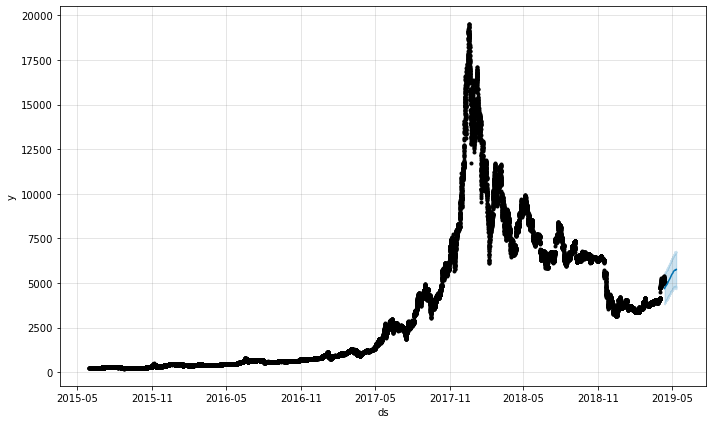

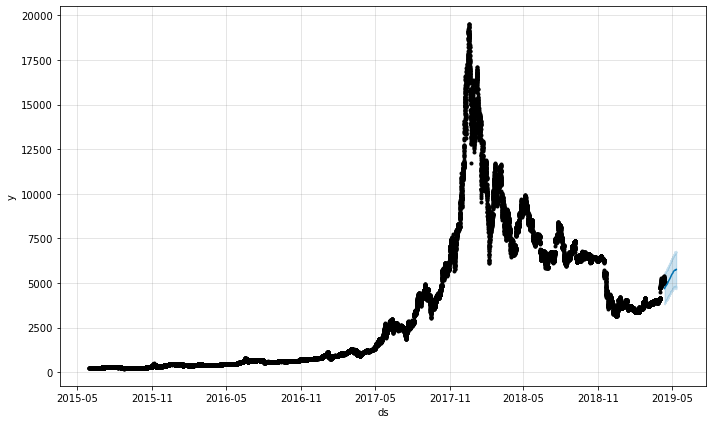

In [116]:
proph.plot(forecast)

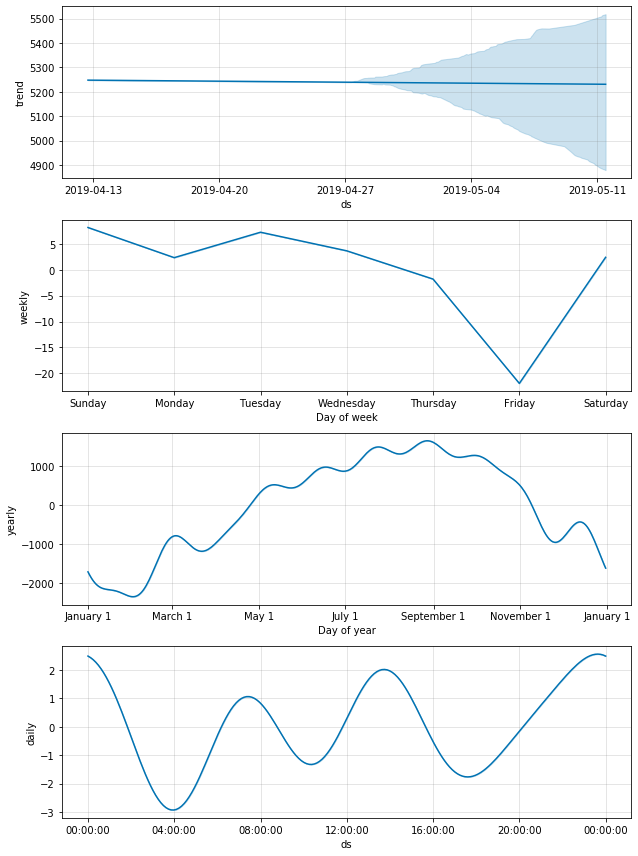

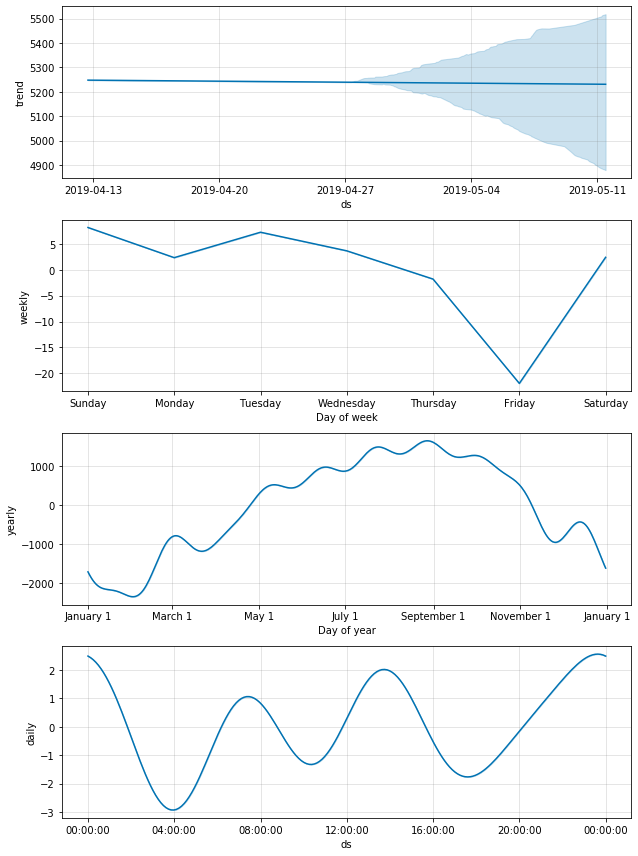

In [117]:
proph.plot_components(forecast)

## Baseline ARIMA model

### Window refitting model

The make_window_refitting_ARIMA_model is taking a really long time to train, as it is retraining for every new observation.

In [216]:
def make_window_refitting_ARIMA_model(df_t = df_train['y'] , df_v = df_val['y'],p = 1, d = 1, q = 0):
    preds = []
    df_t = list(df_t)

    for i in df_v:
        model = ARIMA(df_t, order=(p,d,q)).fit()
        pred = model.forecast()[0][0]
        preds.append(pred)
        df_t.append(i)

    plt.plot(df_v)
    plt.plot(preds)
    rmse = calc_RMSE(validation,np.array(preds))
    print(rmse)
    
    return rmse,df_v,preds,model

In [34]:
# res = make_window_refitting_model(df_t = df_train['y'], p = 1, d = 0 , q = 1)

In [220]:
model = ARIMA(df_train.y, order=(1,0,1)).fit()

In [ ]:
df_val;

## Baseline LSTM Model

In [135]:
# date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_train.columns[1:]]),
#                           data=[i for i in range(len(df_train.columns[1:]))])

# series_array = df_train[df_train.columns[1:]].values

In [136]:
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

In [137]:
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

In [138]:
def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [156]:
def split_sequence(sequence, n_steps = num_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Standradizing for LSTM

In [189]:
std = StandardScaler()

In [232]:
train = df_train.copy()
train.head()

,ds,y
0,2015-05-31 00:00:00,232.00
1,2015-05-31 01:00:00,231.98
2,2015-05-31 02:00:00,232.14
3,2015-05-31 03:00:00,232.38
4,2015-05-31 04:00:00,232.05


In [247]:
train = df_train.copy()
train = np.array(train.y)[:, np.newaxis]
val = df_val.copy()
val = np.array(val.y)[:, np.newaxis]
std.fit(train)

val = std.transform(val)
train = std.transform(train)

In [257]:
num_steps = 72
n_features = 1

array([[-0.87102683],
       [-0.87103226],
       [-0.87098881],
       ...,
       [ 0.44357212],
       [ 0.44388438],
       [ 0.44532077]])

In [261]:
# train = train.y.values

In [262]:
# val = val.y.values

In [259]:
train

array([[-0.87102683],
       [-0.87103226],
       [-0.87098881],
       ...,
       [ 0.44357212],
       [ 0.44388438],
       [ 0.44532077]])

In [249]:
X, y = split_sequence(train, n_steps)

In [250]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [251]:
X

array([[[-0.87102683],
        [-0.87103226],
        [-0.87098881],
        ...,
        [-0.87295469],
        [-0.8728841 ],
        [-0.87291396]],

       [[-0.87103226],
        [-0.87098881],
        [-0.87092364],
        ...,
        [-0.8728841 ],
        [-0.87291396],
        [-0.8728841 ]],

       [[-0.87098881],
        [-0.87092364],
        [-0.87101325],
        ...,
        [-0.87291396],
        [-0.8728841 ],
        [-0.87275105]],

       ...,

       [[ 0.47814067],
        [ 0.48135016],
        [ 0.48489907],
        ...,
        [ 0.44505739],
        [ 0.44607834],
        [ 0.44510898]],

       [[ 0.48135016],
        [ 0.48489907],
        [ 0.48389169],
        ...,
        [ 0.44607834],
        [ 0.44510898],
        [ 0.44357212]],

       [[ 0.48489907],
        [ 0.48389169],
        [ 0.48244172],
        ...,
        [ 0.44510898],
        [ 0.44357212],
        [ 0.44388438]]])

In [266]:
X_val, y_val = split_sequence(val, n_steps)

In [267]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [252]:


LSTM_model_1 = Sequential()
LSTM_model_1.add(LSTM(16, activation='relu', input_shape=(num_steps, n_features)))
# LSTM_model_1.add(Dense(8))
# LSTM_model_1.add(LSTM(16, activation='relu'))
LSTM_model_1.add(Dense(1))
LSTM_model_1.compile(optimizer='adam', loss='mse')

In [253]:
LSTM_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [254]:
history = LSTM_model_1.fit(X, y, epochs=100, batch_size=128, validation_split=0.25)

Train on 25326 samples, validate on 8443 samples
Epoch 1/100
25326/25326 [==============================] - 13s 506us/step - loss: 4.4935 - val_loss: 0.2164
Epoch 2/100
25326/25326 [==============================] - 12s 466us/step - loss: 0.2954 - val_loss: 0.1240
Epoch 3/100
25326/25326 [==============================] - 12s 457us/step - loss: 0.2339 - val_loss: 0.0611
Epoch 4/100
25326/25326 [==============================] - 12s 456us/step - loss: 0.1851 - val_loss: 0.0281
Epoch 5/100
25326/25326 [==============================] - 12s 457us/step - loss: 0.1470 - val_loss: 0.0132
Epoch 6/100
25326/25326 [==============================] - 12s 457us/step - loss: 0.1178 - val_loss: 0.0059
Epoch 7/100
25326/25326 [==============================] - 12s 457us/step - loss: 0.0952 - val_loss: 0.0025
Epoch 8/100
25326/25326 [==============================] - 12s 464us/step - loss: 0.0777 - val_loss: 0.0012
Epoch 9/100
25326/25326 [==============================] - 12s 473us/step - loss: 4.592

Epoch 74/100
25326/25326 [==============================] - 12s 484us/step - loss: 7.9743e-04 - val_loss: 3.7970e-04
Epoch 75/100
25326/25326 [==============================] - 12s 490us/step - loss: 7.9381e-04 - val_loss: 3.5045e-04
Epoch 76/100
25326/25326 [==============================] - 12s 486us/step - loss: 7.9134e-04 - val_loss: 3.3980e-04
Epoch 77/100
25326/25326 [==============================] - 12s 487us/step - loss: 7.8005e-04 - val_loss: 3.5318e-04
Epoch 78/100
25326/25326 [==============================] - 12s 484us/step - loss: 7.6885e-04 - val_loss: 3.5175e-04
Epoch 79/100
25326/25326 [==============================] - 12s 485us/step - loss: 7.7634e-04 - val_loss: 3.3042e-04
Epoch 80/100
25326/25326 [==============================] - 12s 486us/step - loss: 7.7796e-04 - val_loss: 3.7498e-04
Epoch 81/100
25326/25326 [==============================] - 12s 485us/step - loss: 7.6710e-04 - val_loss: 5.6585e-04
Epoch 82/100
25326/25326 [==============================] - 12s 

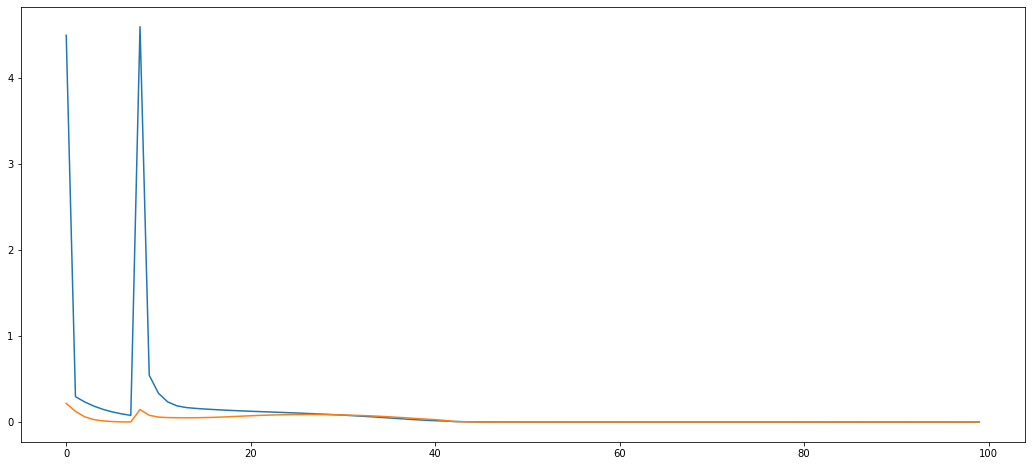

In [255]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [286]:


LSTM_model_2 = Sequential()
LSTM_model_2.add(LSTM(16, activation='relu', input_shape=(num_steps, n_features)))
# LSTM_model_2.add(Dense(8))
# LSTM_model_2.add(LSTM(16, activation='relu'))
LSTM_model_2.add(Dense(1))
LSTM_model_2.compile(optimizer='adam', loss='mse')

In [287]:
history_2 = LSTM_model_2.fit(X, y, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Train on 33769 samples, validate on 619 samples
Epoch 1/100
33769/33769 [==============================] - 17s 507us/step - loss: 0.5075 - val_loss: 0.0034
Epoch 2/100
33769/33769 [==============================] - 15s 452us/step - loss: 0.0148 - val_loss: 5.4571e-04
Epoch 3/100
33769/33769 [==============================] - 15s 452us/step - loss: 0.0019 - val_loss: 3.4029e-04
Epoch 4/100
33769/33769 [==============================] - 16s 465us/step - loss: 0.0012 - val_loss: 2.4501e-04
Epoch 5/100
33769/33769 [==============================] - 16s 460us/step - loss: 9.5149e-04 - val_loss: 2.2599e-04
Epoch 6/100
33769/33769 [==============================] - 16s 461us/step - loss: 9.0372e-04 - val_loss: 2.5732e-04
Epoch 7/100
33769/33769 [==============================] - 16s 464us/step - loss: 8.6225e-04 - val_loss: 2.2103e-04
Epoch 8/100
33769/33769 [==============================] - 16s 465us/step - loss: 8.4849e-04 - val_loss: 2.2583e-04
Epoch 9/100
33769/33769 [===================

Epoch 71/100
33769/33769 [==============================] - 14s 421us/step - loss: 2.5236e-04 - val_loss: 1.0484e-04
Epoch 72/100
33769/33769 [==============================] - 14s 425us/step - loss: 2.5559e-04 - val_loss: 1.0331e-04
Epoch 73/100
33769/33769 [==============================] - ETA: 0s - loss: 2.4983e-0 - 15s 449us/step - loss: 2.5143e-04 - val_loss: 1.1410e-04
Epoch 74/100
33769/33769 [==============================] - 14s 429us/step - loss: 2.5619e-04 - val_loss: 6.7878e-05
Epoch 75/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4696e-04 - val_loss: 6.3019e-05
Epoch 76/100
33769/33769 [==============================] - 14s 422us/step - loss: 2.4641e-04 - val_loss: 8.2700e-05
Epoch 77/100
33769/33769 [==============================] - 14s 420us/step - loss: 2.4503e-04 - val_loss: 6.9561e-05
Epoch 78/100
33769/33769 [==============================] - 14s 421us/step - loss: 2.5311e-04 - val_loss: 6.4097e-05
Epoch 79/100
33769/33769 [==========

In [288]:
LSTM_model_2.save('LSTM_model_2_fit_100epochs.h5')

In [289]:
keras.models.save_model(
    LSTM_model_2,
    'LSTM_model_2_fit_100epochs_2.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [290]:
LSTM_model_3 = Sequential()
LSTM_model_3.add(LSTM(32, activation='relu', input_shape=(num_steps, n_features), dropout=0.05,recurrent_dropout=0.05))
LSTM_model_3.add(Dense(32))
# LSTM_model_3.add(LSTM(16, activation='relu'))
LSTM_model_3.add(Dense(1))
LSTM_model_3.compile(optimizer='adam', loss='mse')



In [291]:
history_3 = LSTM_model_2.fit(X, y, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Train on 33769 samples, validate on 619 samples
Epoch 1/100
33769/33769 [==============================] - 15s 444us/step - loss: 2.4161e-04 - val_loss: 1.4402e-04
Epoch 2/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4129e-04 - val_loss: 8.4394e-05
Epoch 3/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4080e-04 - val_loss: 5.6402e-05
Epoch 4/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4823e-04 - val_loss: 9.6544e-05
Epoch 5/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4032e-04 - val_loss: 5.5833e-05
Epoch 6/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4110e-04 - val_loss: 5.7477e-05
Epoch 7/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3988e-04 - val_loss: 6.0386e-05
Epoch 8/100
33769/33769 [==============================] - 14s 424us/step - loss: 2.3779e-04 - val_loss: 5.8348e-05
Epoch 9/100
33769/33769 

33769/33769 [==============================] - 14s 422us/step - loss: 2.3628e-04 - val_loss: 5.9544e-05
Epoch 71/100
33769/33769 [==============================] - 14s 422us/step - loss: 2.3330e-04 - val_loss: 6.1796e-05
Epoch 72/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3489e-04 - val_loss: 5.6073e-05
Epoch 73/100
33769/33769 [==============================] - 14s 426us/step - loss: 2.3409e-04 - val_loss: 7.5116e-05
Epoch 74/100
33769/33769 [==============================] - 14s 424us/step - loss: 2.3502e-04 - val_loss: 9.0027e-05
Epoch 75/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3320e-04 - val_loss: 8.0231e-05
Epoch 76/100
33769/33769 [==============================] - 14s 422us/step - loss: 2.3904e-04 - val_loss: 9.2309e-05
Epoch 77/100
33769/33769 [==============================] - 14s 426us/step - loss: 2.3498e-04 - val_loss: 5.3780e-05
Epoch 78/100
33769/33769 [==============================] - 14s 424us/step - 

In [292]:
LSTM_model_3.save('LSTM_model_3_fit_100epochs.h5')

In [293]:
keras.models.save_model(
    LSTM_model_3,
    'LSTM_model_3_fit_100epochs_2.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [306]:
df_train.head(3)

,ds,y
0,2015-05-31 00:00:00,232.00
1,2015-05-31 01:00:00,231.98
2,2015-05-31 02:00:00,232.14


In [340]:
# df_vix_FBP.head(3)
# dir(df_vix_FBP.ds.dt)
# df_vix_FBP.ds = df_vix_FBP.ds.dt.tz_localize()

In [338]:
intersecting_dates = pd.to_datetime(df_train.ds, utc=True) & pd.to_datetime(df_vix_FBP.ds, utc = True)
# df_train[intersecting_dates]
intersecting_dates.any()

False

In [347]:
df_gold.head()

,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
0,01/08/2017 0:00,0.097156,1027.0,148.0,403.0,476.0,-0.504061,0.432704,2855.81,2863.06,2823.00,2825.92,184.02,"522951,00"
1,01/08/2017 1:00,0.064507,778.0,143.0,239.0,396.0,-0.381007,0.437953,2823.01,2860.02,2821.01,2853.38,77.3,219605.16
2,01/08/2017 2:00,0.119218,836.0,118.0,333.0,385.0,-0.394999,0.439269,2846.27,2858.04,2837.31,2841.60,135.83,386739.15
3,01/08/2017 3:00,0.004163,984.0,262.0,279.0,443.0,-0.431913,0.420278,2841.84,2863.88,2837.73,2862.93,143.2,408360.03
4,01/08/2017 4:00,0.065608,751.0,133.0,237.0,381.0,-0.405835,0.435645,2862.92,2876.00,2848.11,2874.99,222.53,637045.88


In [341]:
dates_1 = set(pd.to_datetime(df_train.ds, utc=True))

In [342]:
dates_2 = set( pd.to_datetime(df_vix_FBP.ds, utc = True))

In [ ]:
dates_3 = set( pd.to_datetime(df_gold_FBP.ds, utc = True))

In [343]:
intersecting_dates = dates_1 & dates_2

In [339]:
df_vix_FBP.head()

,ds,y
0,2017-01-25 16:00:00+00:00,19.14
1,2017-01-25 17:00:00+00:00,19.14
2,2017-01-25 18:00:00+00:00,19.14
3,2017-01-25 19:00:00+00:00,19.14
4,2017-01-25 20:00:00+00:00,19.14


In [336]:
pd.to_datetime(df_train.ds, utc=True).tail()

33836   2019-04-12 12:00:00+00:00
33837   2019-04-12 13:00:00+00:00
33838   2019-04-12 14:00:00+00:00
33839   2019-04-12 15:00:00+00:00
33840   2019-04-12 16:00:00+00:00
Name: ds, dtype: datetime64[ns, UTC]

In [337]:
pd.to_datetime(df_vix_FBP.ds).tail()

20730   2019-08-06 12:00:00+00:00
20731   2019-08-06 13:00:00+00:00
20732   2019-08-06 14:00:00+00:00
20733   2019-08-06 15:00:00+00:00
20734   2019-08-06 16:00:00+00:00
Name: ds, dtype: datetime64[ns, UTC]

In [344]:
df_vix_FBP[df_vix_FBP.ds.isin(intersecting_dates)]

,ds,y
0,2017-01-25 16:00:00+00:00,19.140
1,2017-01-25 17:00:00+00:00,19.140
2,2017-01-25 18:00:00+00:00,19.140
3,2017-01-25 19:00:00+00:00,19.140
4,2017-01-25 20:00:00+00:00,19.140
5,2017-01-25 21:00:00+00:00,19.140
6,2017-01-25 22:00:00+00:00,19.140
7,2017-01-25 23:00:00+00:00,19.220
8,2017-01-26 00:00:00+00:00,19.330
9,2017-01-26 01:00:00+00:00,19.340


In [345]:
df_train[df_train.ds.isin(intersecting_dates)]

,ds,y
13892,2017-01-01 16:00:00,983.30
13893,2017-01-01 17:00:00,990.92
13894,2017-01-01 18:00:00,995.78
13895,2017-01-01 19:00:00,995.43
13896,2017-01-01 20:00:00,999.52
13897,2017-01-01 21:00:00,1001.90
13898,2017-01-01 22:00:00,1003.85
13899,2017-01-01 23:00:00,998.09
13900,2017-01-02 00:00:00,997.66
13901,2017-01-02 01:00:00,997.93
